In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from helper import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

%load_ext autoreload
%autoreload 2

# Generate data

We provide a helper function which generates artificial datasets

In [2]:
NUM_SAMPLES = 100

blobs_train, blobs_test = generate_dataset("blobs", NUM_SAMPLES)
moons_train, moons_test = generate_dataset("moons", NUM_SAMPLES)
xor_train, xor_test = generate_dataset("xor", NUM_SAMPLES)
squares_train, squares_test = generate_dataset("bar", NUM_SAMPLES)

# The generate_dataset function returns PyTorch dataset objects
type(blobs_train), type(blobs_test)

(torch.utils.data.dataset.Subset, torch.utils.data.dataset.Subset)

Let us plot the train and the test data sets. Note the differences between the two.

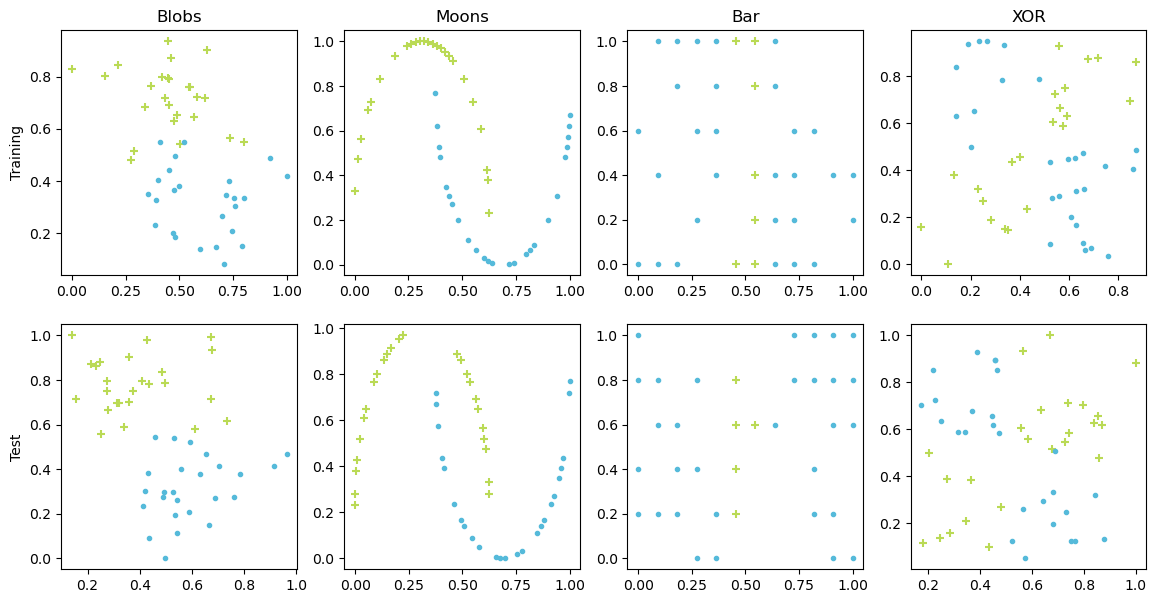

In [3]:
datasets = [
    ("Blobs", blobs_train, blobs_test),
    ("Moons", moons_train, moons_test),
    ("Bar", squares_train, squares_test),
    ("XOR", xor_train, xor_test)
]

visualize_datasets(datasets)

# Optimizing using PyTorch

Write an optimizer in PyTorch by taking using its default SGD class

In [4]:
def optimize(train_data, test_data, model, loss_fn = torch.nn.CrossEntropyLoss(), lr = 0.1, momentum = 0.0):
    """
    Stochastic Gradient Descent optimizer
    
    :param train_data: torch.utils.data.dataset.Subset
    :param test_data: torch.utils.data.dataset.Subset
    :param model: torch.nn.Module (see https://pytorch.org/docs/stable/nn.html)
    :param loss_fn: torch.nn.modules.loss (see https://pytorch.org/docs/stable/nn.html#id51)
    :param lr: float, learning rate
    
    :return:
    - objectives, a list of loss values on the test dataset, collected at the end of each pass over the dataset (epoch)
    """
    # defatult pytorch functions which are useful for loading testing and training data
    train_loader = data.DataLoader(train_data, batch_size=10, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=NUM_SAMPLES)
    losses = []
        
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: Define SGD optimizer with learning rate = lr
    # HINT: Use torch.optim.SGD and model.parameters()
    # ***************************************************
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    # Run SGD
    for epoch in range(1000):
        for minibatch, label in train_loader:
            
            optimizer.zero_grad() # Sets the previously computed gradients to zero to prevent accumulation
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: prediction on minibatch
            # HINT: Use model.forward
            # ***************************************************
            prediction = model.forward(minibatch)
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: compute the loss on prediction
            # HINT: Use loss_fn
            # ***************************************************
            loss = loss_fn(prediction, label)
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: compute the minibatch gradient
            # HINT: Use loss.backward!
            # ***************************************************
            loss.backward()
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: perform an SGD step
            # HINT: Use optimizer.step!
            # ***************************************************
            optimizer.step()
            
        # Compute the test loss
        # we let torch know that we dont intend to call .backward
        with torch.no_grad():
            test_data, test_labels = next(iter(test_loader))  # load the one and only test batch
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: compute the test prediction and test loss
            # ***************************************************
            prediction = model.forward(test_data)
            loss = loss_fn(prediction, test_labels)

            losses.append(loss.item())

            # Print the test loss to monitor progress
            if epoch % 100 == 0:
                print(epoch, loss.item())
                
    return losses

# RBF Kernel

An RBF kernel is the most commonly used `out of the box` kernel method for non-linear data. Intuitively, an RBF-kernel blurs the training data and uses this for classification i.e. the individual green and blue points above get blurred to make green and blue regions, which are used to make predictions. A critical parameter `sigma` defines the width of this blurring---large `sigma` results in more blurring.

See [here](https://github.com/epfml/ML_course/blob/master/lectures/07/lecture07b_kernelRidge.pdf) for more information on the `kernel trick` and [here](https://www.cs.huji.ac.il/~shais/Lectures2014/lecture8.pdf) for an indepth mathematical treatment. Here, we will try develop an intuition for the RBF kernel.

In [5]:
class RadialBasisFunction(torch.nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.gamma = 1 / (2 * sigma ** 2)
        self.num_classes = 2
        self.name = 'RBF'
    
    def init_params(self, train_data):
        # data reshaping to do torch broadcasting magic
        data_matrix = train_data.dataset.tensors[0][train_data.indices, :]
        self.data_matrix = data_matrix.t().view(1, *data_matrix.t().shape)
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: initialize parameters alpha to 0
        # HINT: use torch.zeros
        # ***************************************************
        zeros = torch.zeros(len(data_matrix), self.num_classes)
        
        self.alpha = torch.nn.Parameter(zeros)

    def forward(self, minibatch):
        minibatch = minibatch.view(*minibatch.shape, 1)
        K = torch.exp(
            -self.gamma * torch.sum((self.data_matrix - minibatch) ** 2, dim=1, keepdim=True)
        ).squeeze()
        return K @ self.alpha


Try you code on the blobs data set. Your test loss should be around 0.1 by the end.

0 0.6039173603057861
100 0.12885251641273499
200 0.10002661496400833
300 0.09017284214496613
400 0.08562175929546356
500 0.08359162509441376
600 0.08256132900714874
700 0.08221019804477692
800 0.0820876881480217
900 0.0823662281036377


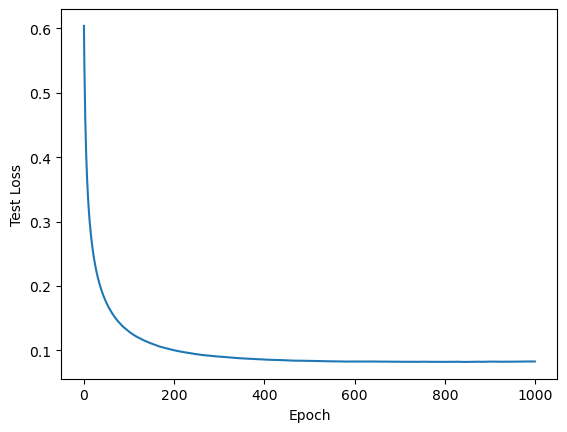

In [6]:
rbf_model = RadialBasisFunction(0.1)
rbf_model.init_params(blobs_train)
rbf_blob_losses = optimize(blobs_train, blobs_test, rbf_model)

plt.plot(rbf_blob_losses)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.show()

Plot the training data points and the predictions made

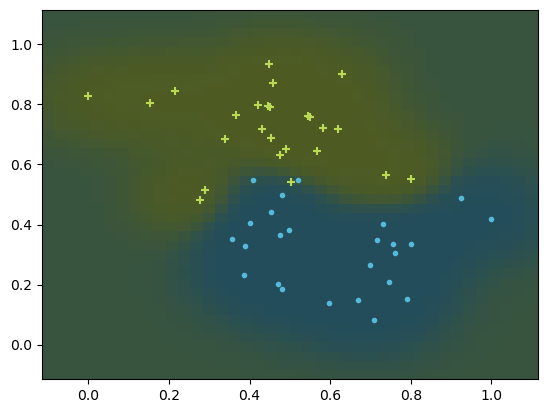

In [7]:
ax = plt.gca()
predict_grid(rbf_model, ax)
visualize_one_dataset(blobs_train, ax)

## Effect of alpha

Plot the results while varying the value of alpha in [0.1, 0.5, 1]. What do you observe? Which is the best value?


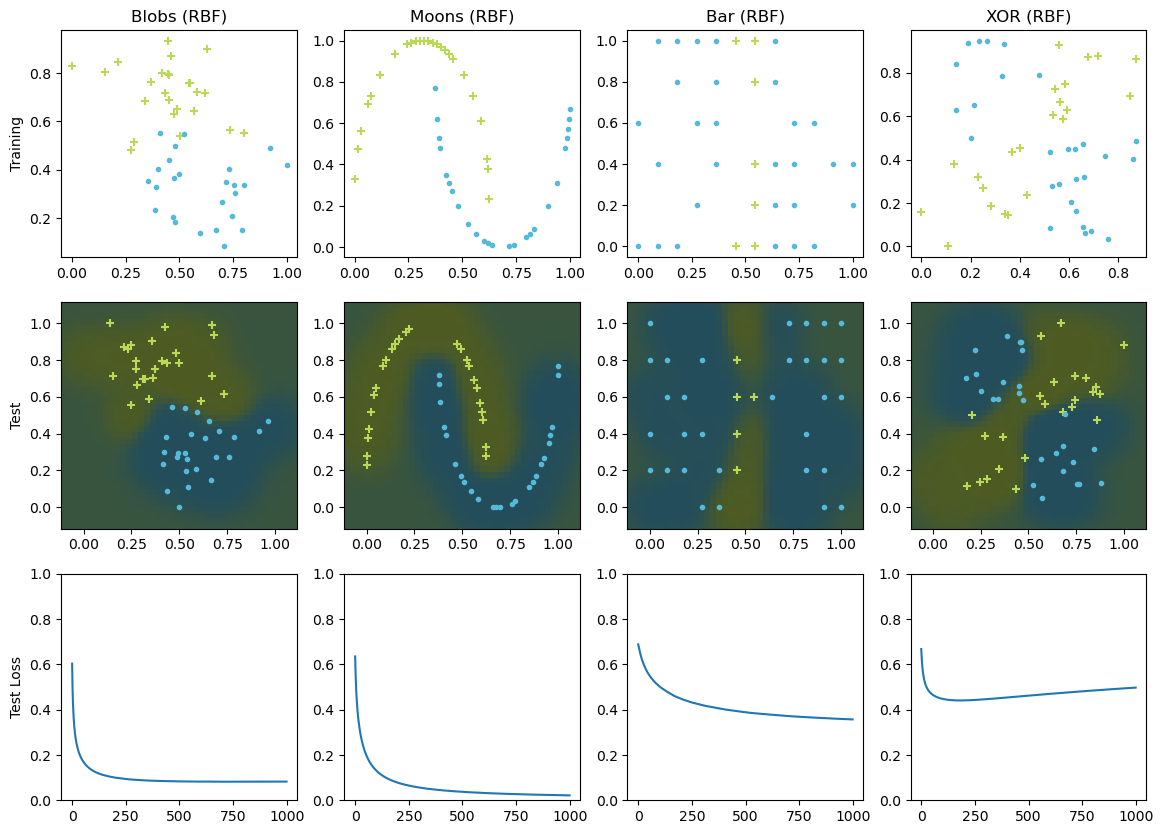

In [8]:
rbf_model = RadialBasisFunction(0.1)
visualize_predictions(datasets, rbf_model, optimize)

# Neural Networks

We will create a simple 2 layer neural network using the default functions provided by PyTorch

In [9]:
class NeuralNetwork(torch.nn.Sequential):
    def __init__(self, hidden_layer_size):
        self.name = 'NN'
        self.num_classes = 2
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: Define your neural network model with ReLU
        # HINT: Use torch.nn.Sequential and torch.nn.ReLU
        # ***************************************************
        super().__init__(
            torch.nn.Linear(2, hidden_layer_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_size, self.num_classes),
        )
        
    def init_params(self, train_data):
        ''' No need to do anything since it is taken care of by torch.nn.Sequential'''
    
        

Plot the results while varying the size of the hidden layer in [20, 200, 1000]

What do you observe?

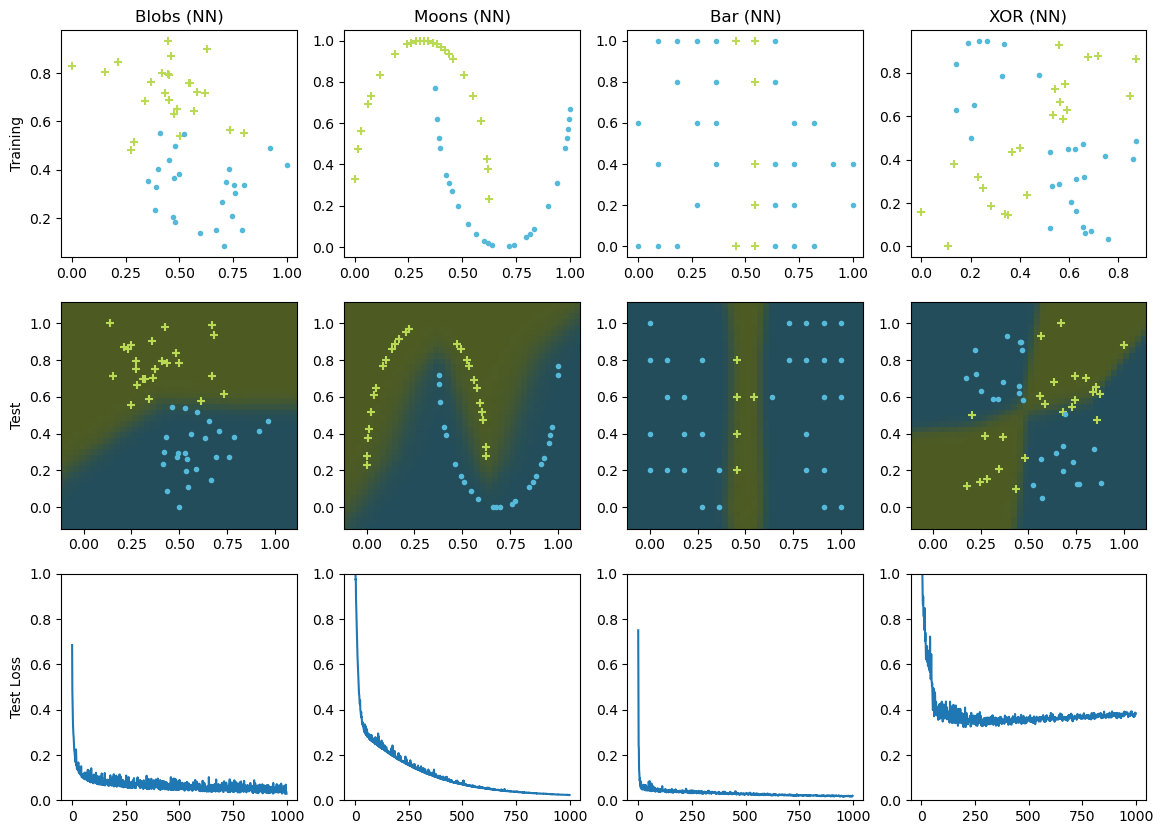

In [10]:
nn_model = NeuralNetwork(200)
visualize_predictions(datasets, nn_model, optimize)

Also try increase the number of layers. How does this effect the classifier learnt?

[This](https://playground.tensorflow.org/) is a cool website where you can play around more with training of neural networks on toy datasets.

## Momentum in training neural networks

In the lecture, we have seen how Nesterov momentum can accelerate gradient descent on convex functions. Let's now explore if similar benefits can be achieved on non-convex functions (neural networks in this case) and for *stochastic* gradient descent. It is important to note that theory usually describes convergence on the training objective. In a typical machine learning setting, however, we care about loss on _unseen_ data. For that reason, here, we will always look at loss on the test set.

__Exercise__<br> Add an argument `momentum` to your function `optimize` completed before. Hint: `torch.optim.SGD` also has a `momentum` argument that you can use. This implements heavy ball momentum, which is similar to, but [slightly different](https://dominikschmidt.xyz/nesterov-momentum/) from Nesterov momentum. You can try either variant, but they should have a similar effect.

### Hyper-parameter tuning

You will be comparing the SGD optimizers without momentum and with momentum of 0.9 (a common value). To do this fairly, you need to find good learning rates for either variant.

__Exercise__<br>
Find a good learning rate for SGD without momentum. You can try different learning rates on an exponential grid (i.e. 0.2, 0.4, 0.8, ...), and record the best test loss in each experiment with `np.min(losses)`. Use `NeuralNetwork(200)` as a model, and use this data:

In [11]:
dataset = datasets[1]  # and use this dataset, you can try others as well
dataset_name = dataset[0]
train_data = dataset[1]
test_data = dataset[2]
dataset_name

'Moons'

Learning rates to try: [0.1 0.2 0.4 0.8 1.6]
0 0.541978657245636
100 0.34347108006477356
200 0.3343323767185211
300 0.2954409718513489
400 0.24449166655540466
500 0.193050816655159
600 0.14507819712162018
700 0.10708457231521606
800 0.07625775784254074
900 0.059744056314229965
0 0.46876537799835205
100 0.348602831363678
200 0.22274965047836304
300 0.12635570764541626
400 0.06804870814085007
500 0.0437273308634758
600 0.030214698985219002
700 0.02086804434657097
800 0.015179790556430817
900 0.012603565119206905
0 0.5901641249656677
100 0.2527722418308258
200 0.09807645529508591
300 0.031230907887220383
400 0.016441673040390015
500 0.010378523729741573
600 0.007740889210253954
700 0.00618997635319829
800 0.00488745141774416
900 0.0043544406071305275
0 0.37080857157707214
100 0.09166915714740753
200 0.01557733304798603
300 0.007486194372177124
400 0.004359097685664892
500 0.003213676856830716
600 0.0024705654941499233
700 0.002095900708809495
800 0.001756666461005807
900 0.001519019599072

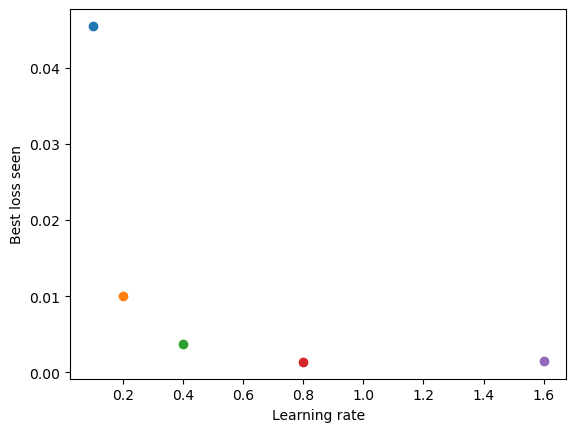

In [12]:
plt.xlabel("Learning rate")
plt.ylabel("Best loss seen")

best_loss = None
best_learning_rate = None

grid = 0.1 * 2**np.arange(5)  # This is chosen by trial and error
print("Learning rates to try:", grid)

for learning_rate in grid:
    model = NeuralNetwork(200)
    test_losses = optimize(train_data, test_data, model, lr=learning_rate)
    best_loss_achieved = np.min(test_losses)
    plt.scatter(learning_rate, best_loss_achieved)
    if best_loss is None or best_loss_achieved < best_loss:
        best_loss = best_loss_achieved
        best_learning_rate = learning_rate

In [13]:
f"The learning rate {best_learning_rate} worked well for SGD without momentum."

'The learning rate 0.8 worked well for SGD without momentum.'

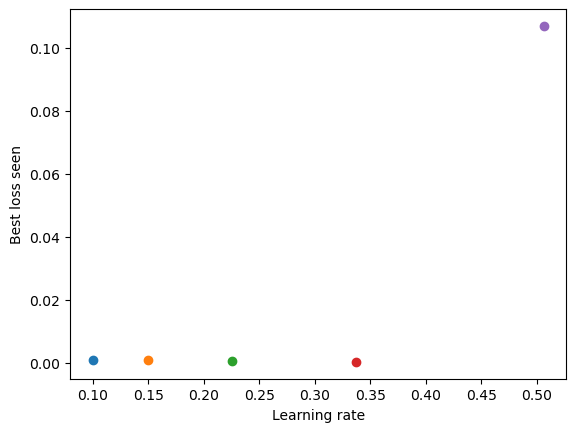

In [14]:
plt.xlabel("Learning rate")
plt.ylabel("Best loss seen")

best_loss = None
best_learning_rate = None

# The grid is chosen by trial and error in this case, 
grid = 0.1 * 1.5**np.arange(5)
print("Learning rates to try:", grid)

for learning_rate in grid:
    model = NeuralNetwork(200)
    test_losses = optimize(train_data, test_data, model, lr=learning_rate, momentum=0.9)
    best_loss_achieved = np.min(test_losses)
    plt.scatter(learning_rate, best_loss_achieved)
    if best_loss is None or best_loss_achieved < best_loss:
        best_loss = best_loss_achieved
        best_learning_rate = learning_rate

In [15]:
f"The learning rate {best_learning_rate} worked well for SGD with 0.9 momentum."

'The learning rate 0.3375 worked well for SGD with 0.9 momentum.'

### Comparing the optimizers

__Exercise__<br>
Plot test loss curves for both optimizers with the best learning rates you found for each. Do you see a benefit of momentum? How stable are the improvements over different datasets or different initializations? Can you think of ways to make the hyperparameter search procedure more stable?

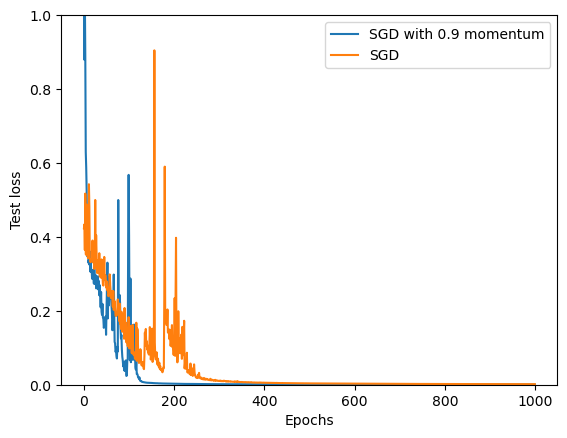

In [16]:
model = NeuralNetwork(200)  # reinitialize the model
plt.plot(optimize(train_data, test_data, model, lr=0.3, momentum=0.9), label="SGD with 0.9 momentum")

model = NeuralNetwork(200)  # reinitialize the model
plt.plot(optimize(train_data, test_data, model, lr=0.8, momentum=0.0), label="SGD")

plt.ylabel("Test loss")
plt.xlabel("Epochs")
plt.ylim([0, 1])
plt.legend();